# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [11]:
# imprtacion de librerias para el trabajo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [2]:
#lectura del data set
data = pd.read_csv('datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.isnull().sum()
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [5]:
print(data.head(5))

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


## Análisis

In [6]:
# cambio de la celda de datetime de obj a datetme
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [7]:
# indexacion de los datos con forme a una hora
data = data.set_index('datetime')
hourly_data = data.resample('1h').sum()

<Axes: title={'center': 'Promedio de pedidos por hora del día'}, xlabel='Hora del día', ylabel='Pedidos promedio'>

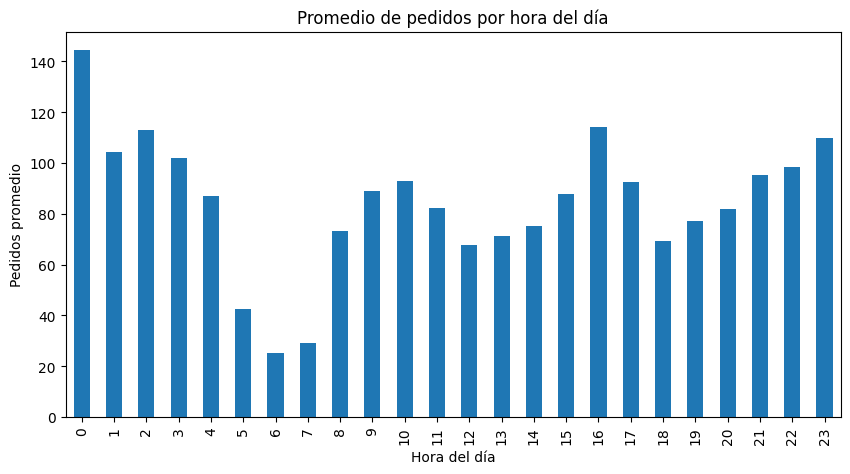

In [8]:
hourly_data['horas'] = hourly_data.index.hour

# Ahora usamos 'horas', no 'hour'
hourly_data.groupby('horas')['num_orders'].mean().plot(
    kind='bar',
    title='Promedio de pedidos por hora del día',
    xlabel='Hora del día',
    ylabel='Pedidos promedio',
    figsize=(10, 5)
)


Se utilizó una gráfica de barras para visualizar la cantidad promedio de pedidos de taxis por cada hora del día. Esta visualización permite identificar las horas con mayor demanda. Se observa que la hora 0 (medianoche) presenta el mayor promedio de pedidos, lo que indica una posible alta demanda nocturna, probablemente relacionada con traslados desde eventos, turnos nocturnos o llegadas al aeropuerto. También se identifican otros picos de demanda en las horas 2, 16 y 23

## Formación

In [9]:
hourly_data['dia'] = hourly_data.index.day
hourly_data['semana'] = hourly_data.index.dayofweek
hourly_data['mes'] = hourly_data.index.month
hourly_data['año'] = hourly_data.index.year

In [ ]:
#division de datos para el entrenamiento de ML
test_size = int(len(hourly_data) * 0.1)

train = hourly_data[:-test_size]
test = hourly_data[-test_size:]

## Prueba

In [15]:
def entrenamiento(features, target):
    # divisiond e entranmiento de 90% prueba y 10% entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=12345) 

    # modelos con los cuales experimentare
    modelos = {
        'Regresion lineal': LinearRegression(),
        'Arbol de decision': DecisionTreeClassifier(random_state=12345),
        'Bosque aleatorio': RandomForestClassifier(n_estimators=100, random_state=12345),
        'XGboost': XGBRegressor(n_estimartors=100, learnig_rate=0.1, random_state=12345, verbosity=0)
    }

    resultados = {}

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        predicciones = modelo.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predicciones))
        resultados[nombre] = rmse 
        print(f"{nombre} - RMSE: {rmse:.2f}")

    return resultados

In [17]:
features = hourly_data[['horas', 'dia', 'semana', 'mes', 'año']]
target = hourly_data['num_orders']

resultados = entrenamiento(features, target)


Regresion lineal - RMSE: 41.32
Arbol de decision - RMSE: 39.17
Bosque aleatorio - RMSE: 38.31
XGboost - RMSE: 24.57


| Modelo               | RECM Resultados|
|----------------------|--------------|
| Regresión lineal     | 41.32     | 
| Árbol de decisión    | 39.17     |
| Bosque aletorio      | 38.31     |
| XGboost              | 24.57     | 

## Conclusion

Se probaron tres modelos clásicos de *Machine Learning* (regresión lineal, árbol de decisión y bosque aleatorio) y un modelo de potenciación del gradiente (*XGBoost*).

- **Regresión lineal** fue el modelo con menor desempeño, con un RECM de 41.32. Sin embargo, cumple con el límite establecido y sirve como prueba de cordura.
- **Árbol de decisión** mejoró ligeramente, con un RECM de 39.17.
- **Bosque aleatorio** obtuvo mejores resultados aún, con un RECM de 38.31, gracias al uso de múltiples árboles.
- **XGBoost** fue el modelo con **mejor desempeño**, alcanzando un RECM de **24.57**, muy por debajo del umbral de 48, lo que representa casi la **mitad del error permitido**.

Por lo tanto, **XGBoost es el modelo recomendado** para su implementación en producción, ya que combina **alta precisión, eficiencia en el tiempo de entrenamiento** y robustez ante datos complejos.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48